# 08. PyTorch Paper Replicating

The goal of machine learning paper replicating is: turn a ML reseach paper into usable code.

In this notebook, we're going to be replicating the Vision Transformer (ViT) with PyTorch

See ground truth notebook here:https://arxiv.org/abs/2010.11929

## 0. Get Setup

Let's import code we've previously written and the required libraries.

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.3.0+cu121
torchvision version: 0.18.0+cu121


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 34.42 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [ ]:
#setup device agnostice code
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#1. Get data

The whole goal of what we're trying to do is to replicate the ViT architecture for FoodVision Mini problem.

We need to get the data.

Pizza, Steak, Sushi images we've been using.

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
#setup train and test directory path
train_dir=image_path/"train"
test_dir=image_path/"test"

train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

##2. Create Datasets and Dataloaders

In [ ]:
from going_modular.going_modular import data_setup

#create image size for transformation
image_size=224 # comes from table 3 of the ViT paper
BATCH_SIZE=32 #paper uses 4096 but this is too big for our smaller compute

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

#CREATE DATALOADER
train_dataloader, test_dataloader, class_names=data_setup.create_dataloaders(train_dir=train_dir,
                             test_dir=test_dir,
                             transform=manual_transforms,
                             batch_size=BATCH_SIZE)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


(<torch.utils.data.dataloader.DataLoader at 0x7f6af91d89a0>,
 ['pizza', 'steak', 'sushi'])

### 2.1 Visualize a single image

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

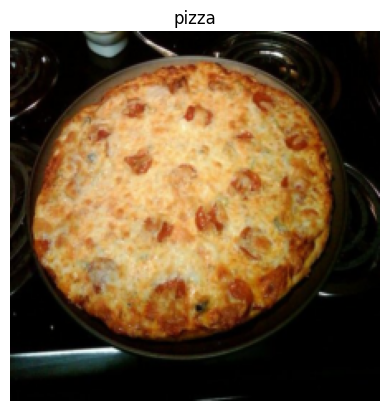

In [ ]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating ViT: Overview

Looking at a whole ML research paper can be intimidating

So we must break it down into smaller components.

* **inputs** - What goes into the model? (in our case, image tensors))
* **outputs** - What comes out of the model/layer/block? (in our case, we want the model to output image classification labels)
* **layers** - Takes an input, manipulates it with a function (for example: self-attnetion)
* **Blocks**- A collection of layers
* **Model** - A collection of blocks

### 3.1 ViT overview: pieces of the puzzle

* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the functions of each layer/block
* Table 1/3: different hyperparameters for the architecture/training.
* Text

#### Figure 1

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png)

* Embedding=learnable representation (start with random numbers and imporve over time)

#### Four-equations

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png)


####Table 1

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png)

### 3.2 Getting specific: What's ViT made of?

There are many little details about the ViT model sprinkled throughout the paper.

Finding them all is like one big treasure hunt!

Remember, a research paper is often months of work compressed into a few pages so it's understandable for it to take of practice to replicate.

However, the main three resources we'll be looking at for the architecture design are:
1. **Figure 1** - This gives an overview of the model in a graphical sense, you could *almost* recreate the architecture with this figure alone.
2. **Four equations in section 3.1** - These equations give a little bit more of a mathematical grounding to the coloured blocks in Figure 1.
3. **Table 1** - This table shows the various hyperparameter settings (such as number of layers and number of hidden units) for different ViT model variants. We'll be focused on the smallest version, ViT-Base.

#### 3.2.1 Exploring Figure 1

Let's start by going through Figure 1 of the ViT Paper.

The main things we'll be paying attention to are:
1. **Layers** - takes an **input**, performs an operation or function on the input, produces an **output**.
2. **Blocks** - a collection of layers, which in turn also takes an **input** and produces an **output**.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs.png" width=900 alt="figure 1 from the original vision transformer paper"/>

*Figure 1 from the ViT Paper showcasing the different inputs, outputs, layers and blocks that create the architecture. Our goal will be to replicate each of these using PyTorch code.*

The ViT architecture is comprised of several stages:
* **Patch + Position Embedding (inputs)** - Turns the input image into a sequence of image patches and adds a position number to specify in what order the patch comes in.
* **Linear projection of flattened patches (Embedded Patches)** - The image patches get turned into an **embedding**, the benefit of using an embedding rather than just the image values is that an embedding is a *learnable* representation (typically in the form of a vector) of the image that can improve with training.
* **Norm** - This is short for "[Layer Normalization](https://paperswithcode.com/method/layer-normalization)" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer [`torch.nn.LayerNorm()`](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).
* **Multi-Head Attention** - This is a [Multi-Headed Self-Attention layer](https://paperswithcode.com/method/multi-head-attention) or "MSA" for short. You can create an MSA layer via the PyTorch layer [`torch.nn.MultiheadAttention()`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html).
* **MLP (or [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron))** - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a `forward()` method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two [`torch.nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers with a [`torch.nn.GELU()`](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) non-linearity activation in between them (section 3.1) and a [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) layer after each (Appendex B.1).
* **Transformer Encoder** - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
* **MLP Head** - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.

You might notice that many of the pieces of the ViT architecture can be created with existing PyTorch layers.

This is because of how PyTorch is designed, it's one of the main purposes of PyTorch to create reusable neural network layers for both researchers and machine learning practitioners.

> **Question:** Why not code everything from scratch?
>
> You could definitely do that by reproducing all of the math equations from the paper with custom PyTorch layers and that would certainly be an educative exercise, however, using pre-existing PyTorch layers is usually favoured as pre-existing layers have often been extensively tested and performance checked to make sure they run correctly and fast.

> **Note:** We're going to be focused on writing PyTorch code to create these layers. For the background on what each of these layers does, I'd suggest reading the ViT Paper in full or reading the linked resources for each layer.

Let's take Figure 1 and adapt it to our FoodVision Mini problem of classifying images of food into pizza, steak or sushi.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs-food-mini.png" width=900 alt="figure 1 from the original vision transformer paper adapted to work with food images, an image of pizza goes in and gets classified as 'pizza'"/>

*Figure 1 from the ViT Paper adapted for use with FoodVision Mini. An image of food goes in (pizza), the image gets turned into patches and then projected to an embedding. The embedding then travels through the various layers and blocks and (hopefully) the class "pizza" is returned.*

#### 3.2.2 Exploring the Four Equations

The next main part(s) of the ViT paper we're going to look at are the four equations in section 3.1.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=650 alt="four mathematical equations from the vision transformer machine learning paper"/>

*These four equations represent the math behind the four major parts of the ViT architecture.*

Section 3.1 describes each of these (some of the text has been omitted for brevity, bolded text is mine):

| **Equation number** | **Description from ViT paper section 3.1** |
| ----- | ----- |
| 1 | ...The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a **trainable linear projection** (Eq. 1). We refer to the output of this projection as the **patch embeddings**... **Position embeddings** are added to the patch embeddings to retain positional information. We use standard **learnable 1D position embeddings**...|
| 2 | The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). **Layernorm (LN) is applied before every block**, and **residual connections after every block** (Wang et al., 2019; Baevski & Auli, 2019). |
| 3 | Same as equation 2. |
| 4 | Similar to BERT's [ class ] token, we **prepend a learnable embedding to the sequence of embedded patches** $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4)... |

Let's map these descriptions to the ViT architecture in Figure 1.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-mapping-the-four-equations-to-figure-1.png" width=1000 alt="mapping the vision transformer paper figure 1 to the four equations listed in the paper"/>

*Connecting Figure 1 from the ViT paper to the four equations from section 3.1 describing the math behind each of the layers/blocks.*

There's a lot happening in the image above but following the coloured lines and arrows reveals the main concepts of the ViT architecture.

How about we break down each equation further (it will be our goal to recreate these with code)?

In all equations (except equation 4), "$\mathbf{z}$" is the raw output of a particular layer:

1. $\mathbf{z}_{0}$ is "z zero" (this is the output of the initial patch embedding layer).
2. $\mathbf{z}_{\ell}^{\prime}$ is "z of a particular layer *prime*" (or an intermediary value of z).
3. $\mathbf{z}_{\ell}$ is "z of a particular layer".

And $\mathbf{y}$ is the overall output of the architecture.

#### 3.2.3 Equation 1 overview

$$
\begin{aligned}
\mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}
$$

This equation deals with the class token, patch embedding and position embedding ($\mathbf{E}$ is for embedding) of the input image.

In vector form, the embedding might look something like:

```python
x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]
```

Where each of the elements in the vector is learnable (their `requires_grad=True`).

#### 3.2.4 Equation 2 overview

$$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}
$$

This says that for every layer from $1$ through to $L$ (the total number of layers), there's a Multi-Head Attention layer (MSA) wrapping a LayerNorm layer (LN).

The addition on the end is the equivalent of adding the input to the output and forming a [skip/residual connection](https://paperswithcode.com/method/residual-connection).

We'll call this layer the "MSA block".

In pseudocode, this might look like:

```python
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
```

Notice the skip connection on the end (adding the input of the layers to the output of the layers).

#### 3.2.5 Equation 3 overview

$$
\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\end{aligned}
$$

This says that for every layer from $1$ through to $L$ (the total number of layers), there's also a Multilayer Perceptron layer (MLP) wrapping a LayerNorm layer (LN).

The addition on the end is showing the presence of a skip/residual connection.

We'll call this layer the "MLP block".

In pseudocode, this might look like:

```python
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

Notice the skip connection on the end (adding the input of the layers to the output of the layers).

#### 3.2.6 Equation 4 overview

$$
\begin{aligned}
\mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & &
\end{aligned}
$$

This says for the last layer $L$, the output $y$ is the 0 index token of $z$ wrapped in a LayerNorm layer (LN).

Or in our case, the 0 index of `x_output_MLP_block`:

```python
y = Linear_layer(LN_layer(x_output_MLP_block[0]))
```

Of course there are some simplifications above but we'll take care of those when we start to write PyTorch code for each section.

> **Note:** The above section covers alot of information. But don't forget if something doesn't make sense, you can always research it further. By asking questions like "what is a residual connection?".

#### 3.2.7 Exploring Table 1

The final piece of the ViT architecture puzzle we'll focus on (for now) is Table 1.

| Model | Layers | Hidden size $D$ | MLP size | Heads | Params |
| :--- | :---: | :---: | :---: | :---: | :---: |
| ViT-Base | 12 | 768 | 3072 | 12 | $86M$ |
| ViT-Large | 24 | 1024 | 4096 | 16 | $307M$ |
| ViT-Huge | 32 | 1280 | 5120 | 16 | $632M$ |

<div align=center>
    <i>Table 1: Details of Vision Transformer model variants. Source: <a href="https://arxiv.org/abs/2010.11929">ViT paper</a>.</i>
</div>
<br>

This table showcasing the various hyperparameters of each of the ViT architectures.

You can see the numbers gradually increase from ViT-Base to ViT-Huge.

We're going to focus on replicating ViT-Base (start small and scale up when necessary) but we'll be writing code that could easily scale up to the larger variants.

Breaking the hyperparameters down:
* **Layers** - How many Transformer Encoder blocks are there? (each of these will contain a MSA block and MLP block)
* **Hidden size $D$** - This is the embedding dimension throughout the architecture, this will be the size of the vector that our image gets turned into when it gets patched and embedded. Generally, the larger the embedding dimension, the more information can be captured, the better results. However, a larger embedding comes at the cost of more compute.
* **MLP size** - What are the number of hidden units in the MLP layers?
* **Heads** - How many heads are there in the Multi-Head Attention layers?
* **Params** - What are the total number of parameters of the model? Generally, more parameters leads to better performance but at the cost of more compute. You'll notice even ViT-Base has far more parameters than any other model we've used so far.

We'll use these values as the hyperparameter settings for our ViT architecture.

## 4. Equation 1: Split data into patches and creating the class, position and patch embedding

Layers=input->function->output

What's the input shape?

What's the output shape?

* Input shape: (224, 224, 3) ->(height, width, colour channels)

* Input image: $H\times{W}\times{C}$ (height x width x colour channels)

* Output shape: ${N \times\left(P^{2} \cdot C\right)}$
* H=height
* W=width
* C=color channels
* P=patch size
* N=number of patches=(height*width) /p^2
* D=constant latent vector size=embedding dimnesion (see Table 1)


* Output shape:

In [ ]:
#create example values
height=224
width=224
color_channels=3
patch_size=16

# Calculate the number of patches
number_of_patches=int(height*width/patch_size**2)
number_of_patches

196

In [ ]:
#input shape
embedding_layer_input_shape=(height, width, color_channels)

#out put shape
embedding_layer_output_shape=(number_of_patches, patch_size**2*color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}-> (number of patches, embedding_dimnesion")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)-> (number of patches, embedding_dimnesion


### 4.2 Turning a single image into patches

Let's visualise visualise visualise

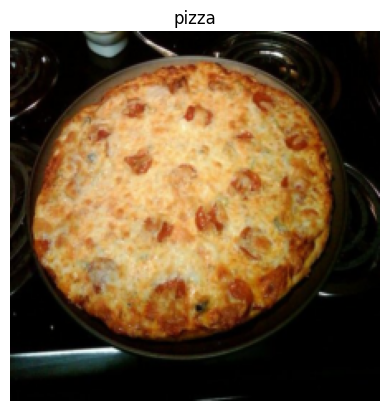

In [ ]:
#View a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

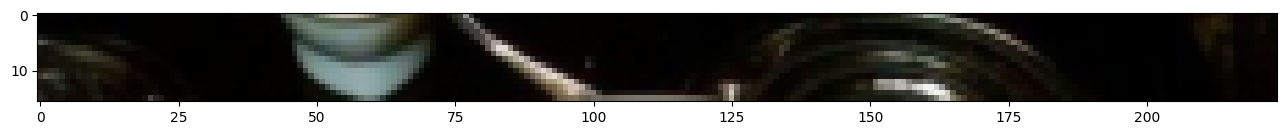

In [ ]:
#Get top row of the image
image_permuted=image.permute(1,2,0) #convert image to color channels last [H,W,C]

#Index to plot the top row of pixels
patch_size=16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size,:,:])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


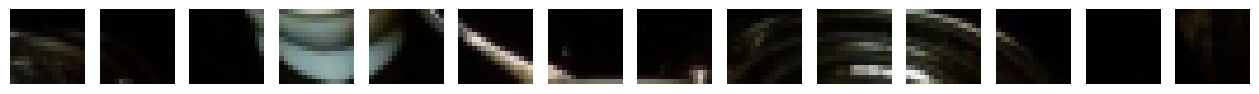

In [ ]:
#Setup code to plot top row as patches
img_size=224
patch_size=16
num_patches=img_size/patch_size
assert img_size % patch_size==0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

#Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size//patch_size,# one column for each patch)
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size,patch_size))

#Iterate through number of patches in the top row
for i, patch in enumerate(range(0,img_size,patch_size)):
    axs[i].imshow(image_permuted[:patch_size,patch:patch+patch_size,:])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].axis("off")

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


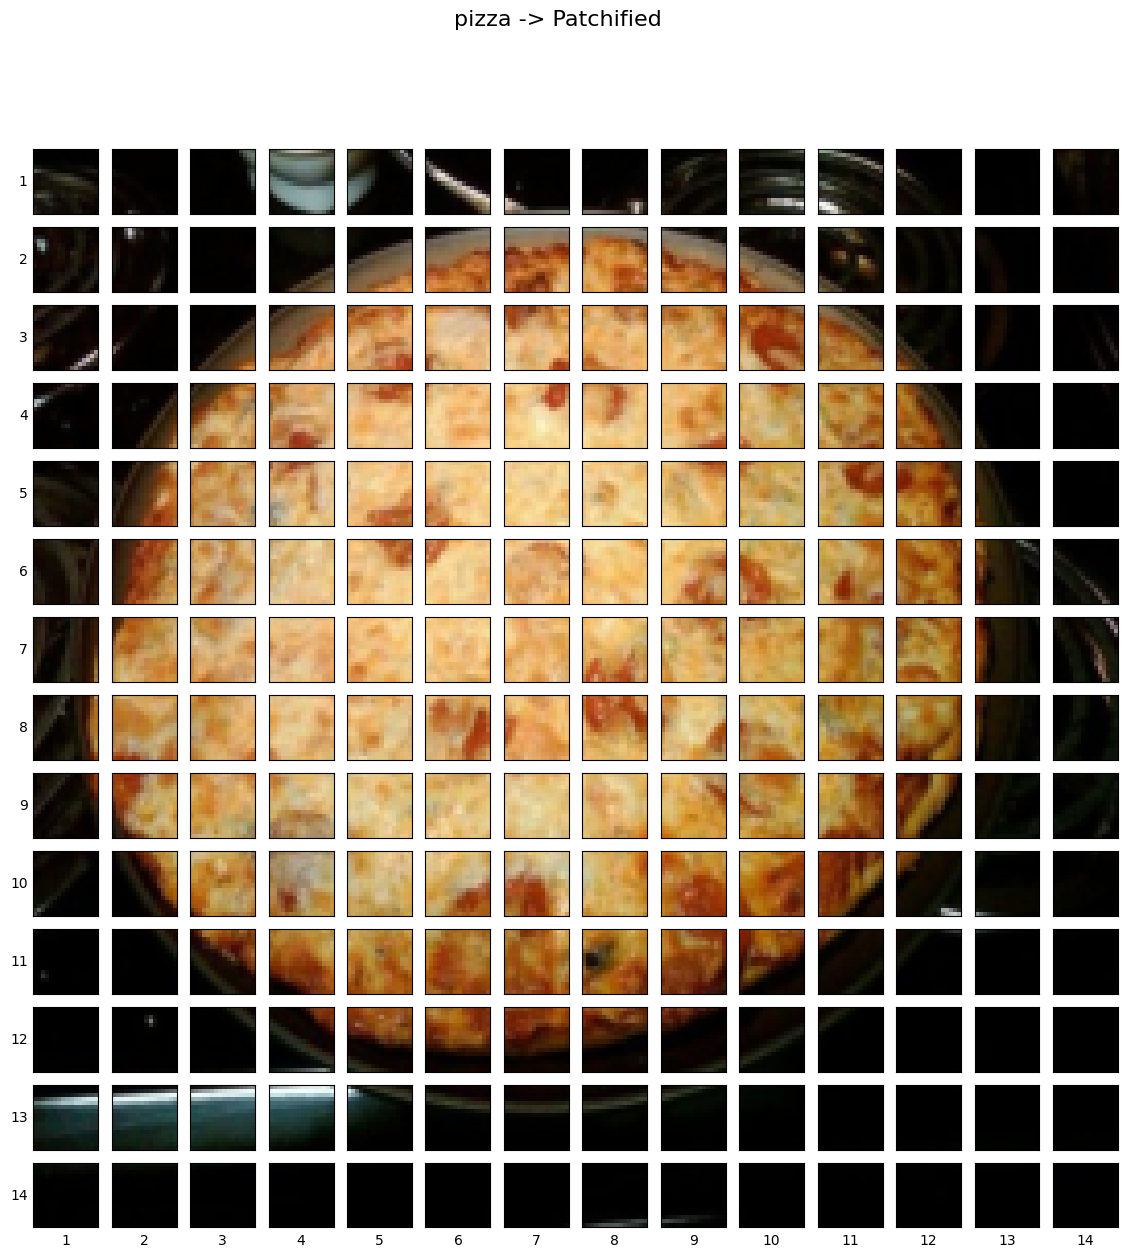

In [ ]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### 4.3 Creating image patches with `torch.nn.Conv2d()` and turning them into Patch Embeddings

Perhaps we could create the image patches and embedding in a single step using `nn.Conv2d()` and we can set the kernel size and stride to `patch_size`

In [ ]:
# Create conv2d payer to turn image into patches of learnable feature maps (embeddings)

from torch import nn

patch_size=16

#Create a conv2d layer with hyperparameters from ViT paper
conv2d=nn.Conv2d(in_channels=3, #for colour images
                out_channels=768, #from table 1 hidden size D for ViT base
                kernel_size=patch_size,
                stride=patch_size,
                 padding=0) #no padding

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

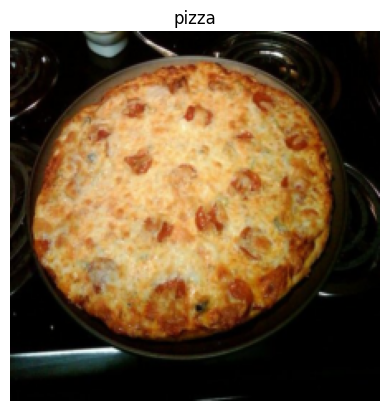

In [ ]:
#view single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [ ]:
#pass image through conv2d layer (must add batch dimension)

image_out_of_conv=conv2d(image.unsqueeze(0))#->[batch_size,color_channels,height,width]
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Now we've passed a single image to our `conv2d` layer it's shape is:

```python
torch.Size([1,768,14,14]) #([batch_size, embedding_dim, feature_map_height, feature_map_width])
```

Showing random convolutional feature maps from indexes: [246, 125, 704, 631, 754]


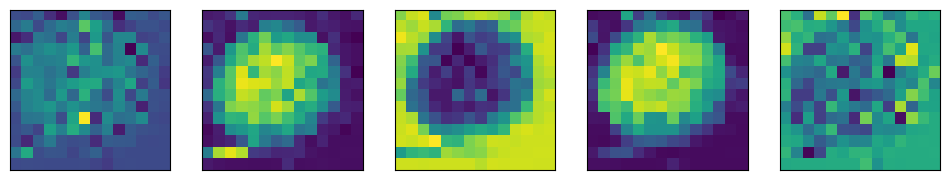

In [ ]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) #remove batch dimension and remove from gradtracking/switch to numpy for matplotlib
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [ ]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 8.1295e-03,  1.9945e-02, -1.7106e-02, -3.8318e-01,  7.6865e-02,
            3.3419e-02,  1.7009e-01,  7.9410e-02, -1.1320e-02, -1.1938e-01,
            7.2716e-02, -1.3047e-02,  1.1816e-02,  4.4615e-03],
          [ 2.4028e-02, -6.4029e-02,  1.3766e-02,  3.1997e-04, -3.9355e-02,
           -9.6780e-02, -1.1063e-01, -5.3881e-02,  4.5059e-03, -2.4991e-02,
            5.7109e-02,  1.3474e-02,  1.7554e-02,  1.2503e-02],
          [-8.2553e-02,  3.7278e-02,  4.2488e-02, -1.2868e-01, -1.4111e-01,
           -2.6931e-01, -2.1992e-01, -2.4055e-01, -1.9238e-01, -5.8963e-02,
           -2.3997e-02,  4.7793e-02,  1.0525e-02,  5.7513e-03],
          [ 7.9900e-03, -3.8811e-03, -2.5355e-01, -2.5911e-01, -2.1033e-01,
           -2.8198e-01, -2.3334e-01, -2.6136e-01, -1.7219e-01, -1.8480e-01,
           -9.2278e-02, -8.0123e-03,  2.1910e-02,  1.0677e-02],
          [ 3.2610e-02, -9.6003e-02, -2.0962e-01, -2.8809e-01, -2.2259e-01,
           -3.1099e-01, -2.6109e-01, -2.6401e-01, -1.8231e-0

The `grad_fn` output of the `single_feature_map` and the `requires_grad=True` attribute means PyTorch is tracking the gradients of this feature map and it will be updated by gradient descent during training.

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

Right now we've a series of convolutional feature maps (patch embeddings) that we want to flatten into a sequence to satisfy the input criteria of the BiT Transformer Encoder


In [ ]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


**Want**: (batch_size, number_of_patches, embedding_dim)

In [ ]:
# Create flatten layer
from torch import nn
flatten_layer = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

flatten_layer(image_out_of_conv), flatten_layer(image_out_of_conv).shape

(tensor([[[ 0.0081,  0.0199, -0.0171,  ...,  0.0165,  0.0159,  0.0161],
          [ 0.0064, -0.0129, -0.0773,  ..., -0.0311, -0.0319, -0.0315],
          [ 0.0316, -0.0016, -0.0600,  ..., -0.0342, -0.0341, -0.0321],
          ...,
          [ 0.0029,  0.0081, -0.0687,  ..., -0.0167, -0.0181, -0.0182],
          [ 0.0178, -0.0248, -0.0655,  ..., -0.0221, -0.0213, -0.0222],
          [-0.0143, -0.0077, -0.0795,  ..., -0.0042, -0.0025, -0.0028]]],
        grad_fn=<ViewBackward0>),
 torch.Size([1, 768, 196]))

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened feature map (patches) shape: torch.Size([1, 768, 196])


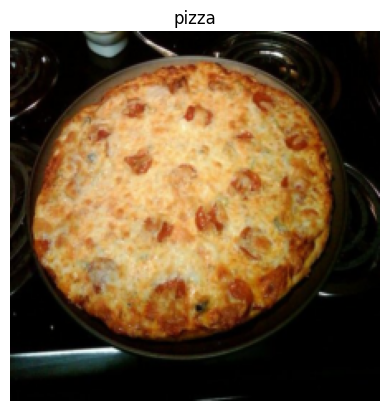

In [ ]:
#put everything together
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")


#turn image into feature maps
image_out_of_conv=conv2d(image.unsqueeze(0))
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

#flatten feature maps
image_out_of_conv_flattened=flatten_layer(image_out_of_conv)
print(f"Flattened feature map (patches) shape: {image_out_of_conv_flattened.shape}")

In [ ]:
#Rearrange output of flattened layer
image_out_of_conv_flattened_reshaped=image_out_of_conv_flattened.permute(0,2,1) #[batch_size,number_of_patches, embedding_dim]
print(f"Reshaped feature map (patches) shape: {image_out_of_conv_flattened_reshaped.shape}")

Reshaped feature map (patches) shape: torch.Size([1, 196, 768])


1. Take a single image.
2. Put in through the convolutional layer (conv2d) to turn the image into 2D feature maps (patch embeddings).
3. Flatten the 2D feature map into a single sequence.

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


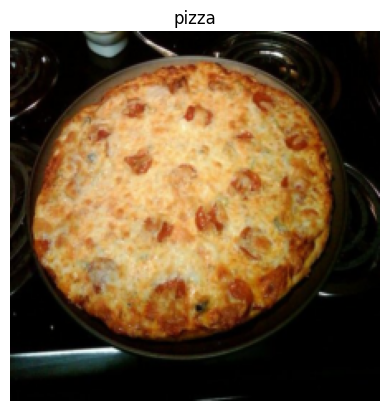

In [ ]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [ ]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


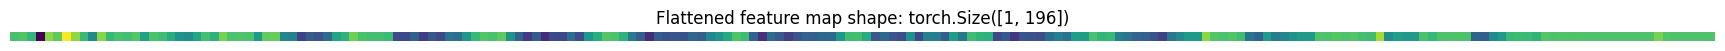

In [ ]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

We want this module to do a few things:
1. Create a class called `PatchEmbedding`
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch_size
3. Create a layer to turn an image into embedding patches using `nn.Conv2d()`
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `forward()` that defines the forward computation (e.g pass through layer from 3 to 4).
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.

In [ ]:
#1. Create a class called PatchEmbedding
class PatchEmbedding(nn.Module):
  #2. Initialize the layer with appropriate hyperparams
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768): #from table 1 for ViT-Base
      super().__init__()

      self.patch_size=patch_size

      #3. Create a layer to turn an image into embedded patches
      self.patcher=nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

      #4. Create a layer to flatten the feature maps of the output of the layer in 3.
      self.flatten=nn.Flatten(start_dim=2,
                              end_dim=3)

  #5. define a forward method to define the forward computation steps
  def forward(self,x):
    #create assertion to check input are correct shape
    image_resolution=x.shape[-1]
    assert image_resolution % patch_size==0, f"Input Image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

    #perform the forward pass
    x_patched=self.patcher(x)
    x_flattened=self.flatten(x_patched)
    #6. Make sure returned sequence embedding dimensions are in the right order (batch_size, number_of_patches,embedding_dimension)
    x_reshaped=x_flattened.permute(0,2,1)

    return x_reshaped

In [ ]:
set_seeds()

#create an instance of patch embedding layer
patch_embedding_layer=PatchEmbedding(in_channels=3,
                                     patch_size=16,
                                     embedding_dim=768)

#check the output shape
print(f"Input Image size {image.unsqueeze(0).shape}")
patch_embedding_image=patch_embedding_layer(image.unsqueeze(0)) #add extra dimension
print(f"Output shape: {patch_embedding_image.shape}")

Input Image size torch.Size([1, 3, 224, 224])
Output shape: torch.Size([1, 196, 768])


In [ ]:
rand_image_tensor=torch.randn(1,3,224,224)
rand_image_tensor_bad=torch.randn(1,3,225,225)

patch_embedding_layer(rand_image_tensor),
#patch_embedding_layer(rand_image_tensor_bad)

(tensor([[[-0.3601,  0.2602, -0.7408,  ..., -1.2910, -0.2012, -0.0354],
          [-0.3405,  0.6132,  0.6626,  ..., -0.6314, -1.8604,  0.3311],
          [-0.0176, -0.2323, -0.1009,  ...,  0.1873,  0.6899, -0.5419],
          ...,
          [ 0.5333, -0.7641, -0.1217,  ...,  0.2381,  0.5565,  0.0466],
          [-0.6577, -0.0324, -0.6278,  ..., -0.1591,  0.7905,  1.4529],
          [-1.1716, -0.1617, -0.1427,  ...,  0.5600,  0.4640,  0.7539]]],
        grad_fn=<PermuteBackward0>),)

### 4.6 Creating the class token embedding

**Want to**: prepend a learnable class token to the start of the patch embedding

In [ ]:
patch_embedding_image

tensor([[[-0.1284, -0.0296, -0.0712,  ...,  0.0307, -0.0089,  0.0022],
         [-0.0353, -0.0173, -0.0461,  ...,  0.0089,  0.0026,  0.0210],
         [-0.0520,  0.1244, -0.0382,  ...,  0.0018, -0.0865,  0.0163],
         ...,
         [-0.0195, -0.0124, -0.0319,  ...,  0.0125, -0.0052,  0.0026],
         [-0.0180, -0.0116, -0.0316,  ...,  0.0105, -0.0041,  0.0039],
         [-0.0205, -0.0115, -0.0304,  ...,  0.0109, -0.0042,  0.0040]]],
       grad_fn=<PermuteBackward0>)

In [ ]:
#get batch size and embedding dimension
batch_size=patch_embedding_image.shape[0]
embedding_dimension=patch_embedding_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [ ]:
#Create class toekn embedding as a learnable parameters that share the same size as the
class_token=nn.Parameter(torch.ones(batch_size,1,embedding_dimension), #normally use randn but using ones for demonstration purposes
                         requires_grad=True)
class_token.shape,patch_embedding_image.shape

(torch.Size([1, 1, 768]), torch.Size([1, 196, 768]))

In [ ]:
#Add the class token embedding to the front of the patch embedding
patch_embedding_image_with_class_token=torch.cat([class_token,patch_embedding_image],dim=1)# number_of_patches dimensions
print(f"Patch embedding image shape: {patch_embedding_image_with_class_token.shape}->(batch_size, class_token+number_of_patches,embedding_dim)")
print(patch_embedding_image_with_class_token)

Patch embedding image shape: torch.Size([1, 197, 768])->(batch_size, class_token+number_of_patches,embedding_dim)
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.1284, -0.0296, -0.0712,  ...,  0.0307, -0.0089,  0.0022],
         [-0.0353, -0.0173, -0.0461,  ...,  0.0089,  0.0026,  0.0210],
         ...,
         [-0.0195, -0.0124, -0.0319,  ...,  0.0125, -0.0052,  0.0026],
         [-0.0180, -0.0116, -0.0316,  ...,  0.0105, -0.0041,  0.0039],
         [-0.0205, -0.0115, -0.0304,  ...,  0.0109, -0.0042,  0.0040]]],
       grad_fn=<CatBackward0>)


In [ ]:
rand_image_tensor=torch.randn(1,3,224,224)
rand_image_tensor_bad=torch.randn(1,3,225,225)

patch_embedding_layer(rand_image_tensor),

(tensor([[[ 5.1667e-02, -7.5159e-04, -4.3578e-01,  ..., -4.7088e-01,
            3.0941e-01,  4.0863e-03],
          [ 3.0909e-01, -4.6872e-01,  6.9165e-03,  ..., -6.5976e-01,
            5.4969e-01,  4.9068e-01],
          [-5.0409e-01,  4.7924e-01,  4.8466e-01,  ...,  1.1693e+00,
            4.7132e-01, -9.3500e-01],
          ...,
          [-6.7677e-01, -1.4702e-02, -6.9565e-02,  ..., -3.8163e-01,
            1.0253e+00, -3.4132e-01],
          [ 3.1300e-01, -2.3472e-01, -3.2696e-01,  ...,  2.7067e-01,
            2.1094e-01,  9.3584e-01],
          [ 7.2666e-01, -5.9672e-02,  1.0471e+00,  ...,  1.6500e-01,
           -9.2721e-02,  7.4571e-01]]], grad_fn=<PermuteBackward0>),)

### 4.7 Creating the position embedding

**Want to**: Create a series of 1D learnable position embeddings and to add them to the sequence of patch embeddings.

In [ ]:
#View the sequence of patch embeddings with the prepended class embedding
patch_embedding_image_with_class_token,patch_embedding_image_with_class_token.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.1284, -0.0296, -0.0712,  ...,  0.0307, -0.0089,  0.0022],
          [-0.0353, -0.0173, -0.0461,  ...,  0.0089,  0.0026,  0.0210],
          ...,
          [-0.0195, -0.0124, -0.0319,  ...,  0.0125, -0.0052,  0.0026],
          [-0.0180, -0.0116, -0.0316,  ...,  0.0105, -0.0041,  0.0039],
          [-0.0205, -0.0115, -0.0304,  ...,  0.0109, -0.0042,  0.0040]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [ ]:
#Calculate N (number of patches)
number_of_patches=int((height*width/patch_size**2))

#Get the embedding dimension
embedding_dimension=patch_embedding_image_with_class_token.shape[-1]

#Create the learnable 1D position embedding
position_embedding=nn.Parameter(torch.ones(1,
                                            number_of_patches+1,
                                            embedding_dimension),
                                requires_grad=True)
position_embedding.shape,position_embedding

(torch.Size([1, 197, 768]),
 Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True))

In [ ]:
#Add position emedding to the patch and class token embedding
patch_and_position_embedding=patch_embedding_image_with_class_token+position_embedding
print(patch_and_position_embedding)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape} -> (batch_size, number_of_patches+1, embedding_dim)")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.8716, 0.9704, 0.9288,  ..., 1.0307, 0.9911, 1.0022],
         [0.9647, 0.9826, 0.9539,  ..., 1.0089, 1.0026, 1.0210],
         ...,
         [0.9805, 0.9876, 0.9681,  ..., 1.0125, 0.9948, 1.0026],
         [0.9820, 0.9884, 0.9684,  ..., 1.0105, 0.9959, 1.0039],
         [0.9795, 0.9885, 0.9696,  ..., 1.0109, 0.9958, 1.0040]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768]) -> (batch_size, number_of_patches+1, embedding_dim)


### 4.8 Putting it all together: from image to embedding

We've written code to turn an image in a flattened sequence of patch embeddings.

Let's outline the steps:

1. Setting the patch size (we'll use **16** as it's widely used throughout the paper and for ViT-Base).
2. Getting a single image, printing its shape and storing its height and width.
3. Adding a batch dimension to the single image so it's compatible with our `PatchEmbedding` layer.
4. Creating a PatchEmbedding layer (the one we made in section 4.5) with a `patch_size=16` and `embedding_dim=768` (from Table 1 for ViT-Base).
5. Passing the single image through the `PatchEmbedding` layer in 4 to create a sequence of patch embeddings.
6. Creating a class token embedding like in section 4.6.
7. Prepending the class token embedding to the patch embeddings created in step 5.
8. Creating a position embedding like in section 4.7.
9. Adding the position embedding to the class token and patch embeddings created in step 7.

In [ ]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## 5. Equation 2: Multi-Head Attention (MSA-Multi-headed self-attention)

* Mutlihead self-attention: which part of a sequence should pay the most attention to itself?
  * In our case we have a series of embedded image patches, which patch significantly relates to another patch.
  * We want our neural network (ViT) to learn this relathionship/representation.


$$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}
$$

Indicates a MSA layer wrapped in a LayerNorm (LN) layer with a residual connection (input to the layer gets added to the output of the layer).

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-mapping-the-four-equations-to-figure-1.png" width=1000 alt="mapping the vision transformer paper figure 1 to the four equations listed in the paper"/>

We can use:
* **Multi-Head Self Attention (MSA)** - `torch.nn.MultiheadAttention()` - https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html
* **Norm (LN or LayerNorm)** - `torch.nn.LayerNorm()` - Layer normalisation is a technique to normalise the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.
  * Normalization=mak everything the same mean and same standard deviation.
  * In PyTorch=https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html
  normalizes values over $D$ dimension, in our case, the $D$ dimension is the embedding dimension.
    * When we normalize along the embedding dimension, it's like making all the stiars in a staircase the same size.
* **Residual connection** - add the input to output (we'll see this later on when we create the full Transformer Encoder block in section 7.1).

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """
  Creates a multihead self-attention block ("MSA block" for short).
  """
  def __init__(self,
               embedding_dim:int=768, #Hidden size D from Table 1 for ViT Base
               num_heads:int=12, #Heads from Table 1 for ViT-Base
               attn_dropout:float=0.0 # doesn't look like the paper uses any dropout in MSABlocks
               ):
    super().__init__()

    #3.Create tthe Norm LAyer (LN)
    self.layer_norm=nn.LayerNorm(normalized_shape=embedding_dim)

    #4.Create the Multi-Head Attention MSA layer
    self.multihead_attn=nn.MultiheadAttention(embed_dim=embedding_dim,
                                              num_heads=num_heads,
                                              dropout=attn_dropout,
                                              batch_first=True) #does the batch dimension come first? (batch, seq, feature) -> (batch, number_of_patches, embedding dimension


  # 5. Create a forward() method to pass the data throguh the layers
  def forward(self,x):
    x=self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?

    return attn_output

In [ ]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


In [ ]:
patch_and_position_embedding, patched_image_through_msa_block

(tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.8716, 0.9704, 0.9288,  ..., 1.0307, 0.9911, 1.0022],
          [0.9647, 0.9826, 0.9539,  ..., 1.0089, 1.0026, 1.0210],
          ...,
          [0.9805, 0.9876, 0.9681,  ..., 1.0125, 0.9948, 1.0026],
          [0.9820, 0.9884, 0.9684,  ..., 1.0105, 0.9959, 1.0039],
          [0.9795, 0.9885, 0.9696,  ..., 1.0109, 0.9958, 1.0040]]],
        grad_fn=<AddBackward0>),
 tensor([[[-0.0956,  0.0071,  0.0446,  ..., -0.3120,  0.7303, -0.3717],
          [-0.0423, -0.0299,  0.0282,  ..., -0.2332,  0.7197, -0.3972],
          [-0.1077, -0.0196,  0.0737,  ..., -0.2410,  0.7044, -0.3537],
          ...,
          [-0.1213, -0.0347,  0.0463,  ..., -0.2437,  0.7183, -0.3585],
          [-0.1258, -0.0381,  0.0474,  ..., -0.2404,  0.7155, -0.3570],
          [-0.1268, -0.0342,  0.0465,  ..., -0.2414,  0.7144, -0.3573]]],
        grad_fn=<TransposeBackward0>))

## 6. Equation 3: Multilayer Perceptron (MLP)

* **MLP** = The MLP contains two layers with GELU non-linearity (section 3.1).
  * MLP=a quite broad term for a block with a series of layer(s), layers can be multiple or even only one layer.
  * Layers can mean: fully-connected, dense, linear, feed-forward, al are often similar names for the same thing. In PyTorch, they're often called `torch.nn.Linear()` and in TensorFlow they might be called `tf.keras.layers.Dense()`
  * GeLU in PyTorch:- https://pytorch.org/docs/stable/generated/torch.nn.GELU.html
  * MLP number of hidden units=MLP Size in Table 1
* **Dropout**=Dropout when used is applied after every dense layer except for the qkv-projections and directly after adding positional to patch embeddings. Hybrid models are trained with the exact setup as their ViT counterparts.
  Value for Dropout available in Table 3

$$
\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\end{aligned}
$$

In pseudcode:

```python
#MLP
x=linear->non-linear->dropout->linear->dropout
```

This says that for every layer from $1$ through to $L$ (the total number of layers), there's also a Multilayer Perceptron layer (MLP) wrapping a LayerNorm layer (LN).

### 6.1 The MLP Layer(s)

The term MLP is quite broad as it can refer to almost any combination of multiple layers (hence the "multi" in multilayer perceptron).

But it generally follows the pattern of:

`linear layer -> non-linear layer -> linear layer -> non-linear layer`

In the the case of the ViT paper, the MLP structure is defined in section 3.1:

  The MLP contains two layers with a GELU non-linearity.

Where "two layers" refers to linear layers (`torch.nn.Linear()` in PyTorch) and "GELU non-linearity" is the GELU (Gaussian Error Linear Units) non-linear activation function (`torch.nn.GELU()` in PyTorch).

Note: A linear layer (`torch.nn.Linear()`) can sometimes also be referred to as a "dense layer" or "feedforward layer". Some papers even use all three terms to describe the same thing (as in the ViT paper).

##6.2 Replicating Equation 3 with PyTorch layers
Let's put everything we've discussed about the LayerNorm (LN) and MLP (MSA) layers in equation 3 into practice.

To do so, we'll:

1. Create a class called `MLPBlock` that inherits from `torch.nn.Module`.
Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
Create a layer normalization (LN) layer with `torch.nn.LayerNorm()` with the `normalized_shape` parameter the same as our embedding dimension ($D$ from Table 1).
Create a sequential series of MLP layers(s) using `torch.nn.Linear()`, `torch.nn.Dropout()` and `torch.nn.GELU()` with appropriate hyperparameter values from Table 1 and Table 3.
Create a `forward()` method for our class passing the in the inputs through the LN layer and MLP layer(s)

In [ ]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
  """
  Creates a layer normalized multilayer perceptron block.
  """
  #2. Initialize the class with hyperparameters from Table 1 and Table 3
  def __init__(self,
               embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        #3. Create a layer normalization layer
        self.layer_norm=nn.LayerNorm(normalized_shape=embedding_dim)

        #4. Create a sequential series of MLP layers
        self.mlp=nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=mlp_dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), #takes back to embedding
            nn.Dropout(p=mlp_dropout) # 'Dropout, when used, is applied after every dense layer
        )

  #5. Create a forward method to pass the data through the layers
  def forward(self,x):
    x=self.layer_norm(x)
    x=self.mlp(x)
    return x

In [ ]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     mlp_dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


In [ ]:
patched_image_through_msa_block, patched_image_through_mlp_block

(tensor([[[-0.0956,  0.0071,  0.0446,  ..., -0.3120,  0.7303, -0.3717],
          [-0.0423, -0.0299,  0.0282,  ..., -0.2332,  0.7197, -0.3972],
          [-0.1077, -0.0196,  0.0737,  ..., -0.2410,  0.7044, -0.3537],
          ...,
          [-0.1213, -0.0347,  0.0463,  ..., -0.2437,  0.7183, -0.3585],
          [-0.1258, -0.0381,  0.0474,  ..., -0.2404,  0.7155, -0.3570],
          [-0.1268, -0.0342,  0.0465,  ..., -0.2414,  0.7144, -0.3573]]],
        grad_fn=<TransposeBackward0>),
 tensor([[[ 0.0888, -0.0153,  0.1148,  ..., -0.0000, -0.0816,  0.2604],
          [ 0.0584, -0.1129,  0.2331,  ..., -0.1357, -0.1413,  0.2368],
          [ 0.1708, -0.1003,  0.2802,  ..., -0.0000, -0.1674,  0.2020],
          ...,
          [ 0.0073, -0.0356,  0.2473,  ...,  0.0080, -0.2183,  0.3270],
          [ 0.0535,  0.0460,  0.0000,  ..., -0.0075, -0.1592,  0.1112],
          [ 0.1002, -0.0358,  0.2372,  ..., -0.1661, -0.1411,  0.2682]]],
        grad_fn=<MulBackward0>))

## 7. Create the Transformer Encoder

The transformer encoder is a combination of alternating blocks of MSA (equation 2) and MLP (equation 3).

Ant there are residual connections between each block.

* Encoder=turn a sequence into learnable representation
* Decoder=go from learn representation back to some sort of sequence
* Residual connections=add a layer(s) input to its subsequent output, this enables the creation of deeper networks (prevents weights from getting too small)

In pseudocode:
```python
#Transformer Encoder
x_input->MSA_block->[MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] ->.......
```

### 7.1 Creating a Transformer Encoder by combining our custom made layers

Enough talk, let's see this in action and make a ViT Transformer Encoder with PyTorch by combining our previously created layers.

To do so, we'll:

1. Create a class called `TransformerEncoderBlock that inherits from `torch.nn.Module`.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Instantiate a MSA block for equation 2 using our `MultiheadSelfAttentionBlock` from section 5.2 with the appropriate parameters.
4. Instantiate a MLP block for equation 3 using our `MLPBlock` from section 6.2 with the appropriate parameters.
5. Create a `forward()` method for our `TransformerEncoderBlock` class.
6. Create a residual connection for the MSA block (for equation 2).
7. Create a residual connection for the MLP block (for equation 3).

In [ ]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block =  MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   mlp_dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x #residual/skip connection for equation 2

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x #residual/skip connection for equation 3

        return x

In [ ]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# # # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Creatin a Transformer Encoder with PyTorch Transformer layers

So far we've built the components of and the Transformer Encoder layer itself ourselves.

But because of their rise in popularity and effectiveness, PyTorch now has in-built Transformer layers as part of `torch.nn`. (https://pytorch.org/docs/stable/nn.html#transformer-layers)

For example, we can recreate the `TransformerEncoderBlock` we just created using `torch.nn.TransformerEncoderLayer()` and setting the same hyperparameters as above.

In [ ]:
#create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer=torch.nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
# # Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

Why spend all this time recreating the transformer encoder when we could've just made it in a single layer?

Practice.

Now we know how things are implemented behind the scnes we can tweak them if necessary?

What are the benefits of using a pre-built PyTorch layer?

* Less prone to errors (goes through a bunch of testing)
* Potential benifit of spped ups (performance boosts)

## Putting it all together to create ViT

1. Create a class called `ViT` that inherits from `torch.nn.Module`.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Make sure the image size is divisible by the patch size (the image should be split into even patches).
4. Calculate the number of patches using the formula $N=H W / P^{2}$, where $H$ is the image height, $W$ is the image width and $P$ is the patch size.
5. Create a learnable class embedding token (equation 1) as done above in section 4.6.
6. Create a learnable position embedding vector (equation 1) as done above in section 4.7.
7. Setup the embedding dropout layer as discussed in Appendix B.1 of the ViT paper.
8. Create the patch embedding layer using the `PatchEmbedding` class as above in section 4.5.
9. Create a series of Transformer Encoder blocks by passing a list of `TransformerEncoderBlock`s created in section 7.1 to `torch.nn.Sequential()` (equations 2 & 3).
10. Create the MLP head (also called classifier head or equation 4) by passing a `torch.nn.LayerNorm()` (LN) layer and a `torch.nn.Linear(out_features=num_classes)` layer (where `num_classes` is the target number of classes) linear layer to `torch.nn.Sequential()`.
11. Create a `forward()` method that accepts an input.
12. Get the batch size of the input (the first dimension of the shape).
13. Create the patching embedding using the layer created in step 8 (equation 1).
14. Create the class token embedding using the layer created in step 5 and expand it across the number of batches found in step 11 using `torch.Tensor.expand()` (equation 1).
15. Concatenate the class token embedding created in step 13 to the first dimension of the patch embedding created in step 12 using `torch.cat()` (equation 1).
16. Add the position embedding created in step 6 to the patch and class token embedding created in step 14 (equation 1).
17. Pass the patch and position embedding through the dropout layer created in step 7.
18. Pass the patch and position embedding from step 16 through the stack of Transformer Encoder layers created in step 9 (equations 2 & 3).
19. Pass index 0 of the output of the stack of Transformer Encoder layers from step 17 through the classifier head created in step 10 (equation 4).
20. Dance and shout woohoo!!! We just built a Vision Transformer!

In [ ]:
#create a ViT class
class ViT(nn.Module):
  def __init__(self,
               img_size=224, #Table 3 from ViT paper
               in_channels=3,
               patch_size:int=16,
               num_transformer_layers:int=12, #Table 1 for Layers for ViT-Base
               embedding_dim:int=768, #Hidden size D from Table 1 for ViT base
               mlp_size:int=3072, #Table 1
               num_heads:int=12, #Table 1 for Heads for ViT-Base
               attn_dropout:int=0,
               mlp_dropout:int=0.1,
               embedding_dropout:int=0.1, #Dropout for patch and position embeddings
               num_classes:int=3 #number of classes in our classification probelm#
               ):
      super().__init__()

    #Make an asertion that image_size is compatible with the patch_size
      assert img_size%patch_size==0,f"Image size {img_size} must be divisible by patch size {patch_size}"

    #calculate the number of patches
      self.num_patches=int((img_size*img_size)/patch_size**2)

      #Create learnable class embedding (needs to goat front of sequence of patches
      self.class_embedding=nn.Parameter(data=torch.randn(1,1,embedding_dim),
                                      requires_grad=True)

      #Create learnable position embedding
      self.position_embedding=nn.Parameter(data=torch.randn(1,self.num_patches+1,embedding_dim),
                                            requires_grad=True)

      #Create embedding dropout value
      self.class_embedding_dropout=nn.Dropout(p=embedding_dropout)

      #Create patch embedding layer
      self.patch_embedding_layer=PatchEmbedding(in_channels=in_channels,
                                                 patch_size=patch_size,
                                                 embedding_dim=embedding_dim)


      #Create the TRansformer Encoder block
      self.transformer_encoder=nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                      num_heads=num_heads,
                                                                      mlp_size=mlp_size,
                                                                      mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

      #create classifier head
      self.classifier=nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
         )

  # 11. Create a forward() method
  def forward(self, x):

    # 12. Get batch size
    batch_size = x.shape[0]

    # 13. Create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

    # 14. Create patch embedding (equation 1)
    x = self.patch_embedding_layer(x)

    # 15. Concat class embedding and patch embedding (equation 1)
    x = torch.cat((class_token, x), dim=1) # batch_size, number_patches, embedding_dim

    # 16. Add position embedding to patch embedding (equation 1)
    x = self.position_embedding + x

    # 17. Run embedding dropout (Appendix B.1)
    x = self.class_embedding_dropout(x)

    # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
    x = self.transformer_encoder(x)

    # 19. Put 0 index logit through classifier (equation 4)
    x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

    return x

In [ ]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [ ]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

###8.1 Getting a visual summary of our ViT model

In [ ]:
from torchinfo import summary

# # Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding_layer)                     [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (class_embedding_dropout)                          [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## 9. Setting up training code for our ViT model

We've replicated the ViT architecture, now let's see how it performs on out FoodVision Mini data.

###9.1 Creating an optimizer

The paper states it uses the Adam optimizer (section 4, TRaining & fine-tuning) with $B1$ value of 0.9, $B2$ of 0.9999 (defaults) and a weight decay of 0.1.

Weight decay=Weight decay is a regularization technique by adding a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss function.

Regularization technique=prevents overfitting.

In [ ]:
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.9999),
                             weight_decay=0.1)

### 9.2 Creating a loss function

The ViT paper doesn't mention what loss function the used.

Since it's multi-class problem we'll use `torch.nn.CrossEntropyLoss()`

In [ ]:
loss_fn=torch.nn.CrossEntropyLoss()

### 9.3 Training the ViT Model

In [ ]:
from going_modular.going_modular import engine

set_seeds()

results=engine.train(model=vit,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=10,
                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.8777 | train_acc: 0.3008 | test_loss: 1.0395 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.5154 | train_acc: 0.3047 | test_loss: 1.5081 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.4131 | train_acc: 0.2617 | test_loss: 1.4600 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.2588 | train_acc: 0.4102 | test_loss: 1.9568 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.3015 | train_acc: 0.2812 | test_loss: 1.6413 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.2499 | train_acc: 0.2930 | test_loss: 1.7576 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1797 | train_acc: 0.4141 | test_loss: 3.2645 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.4590 | train_acc: 0.2852 | test_loss: 1.3926 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.3438 | train_acc: 0.3672 | test_loss: 1.2999 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.4173 | train_acc: 0.3164 | test_loss: 1.3354 | test_acc: 0.2604


### 9.4 What our training setup is missing

The original ViT architecture achieves good results on several image classification benchmarks (on par or better than many state-of-the-art results when it was released).

However, our results (so far) aren't as good.

There's a few reasons this could be but the main one is scale.

The original ViT paper uses a far larger amount of data than ours (in deep learning, more data is generally always a good thing) and a longer training schedule (see Table 3).

The main things our training implementation is missing:

Prevent underfitting:
* Data - our setup uses far less data (225 vs millions)

Prevent overfitting:
* Learning rate warmup- start with a low learning rate and increase to a base LR
* Learning rate decay - as your model gets closer to convergence, start to lower the learning rate
* Gradient clipping - prevent gradients from getting too big



### 9.5 Plot the loss curves of our ViT model
To check out our ViT model's loss curves, we can use the `plot_loss_curves` function from `helper_functions.py`

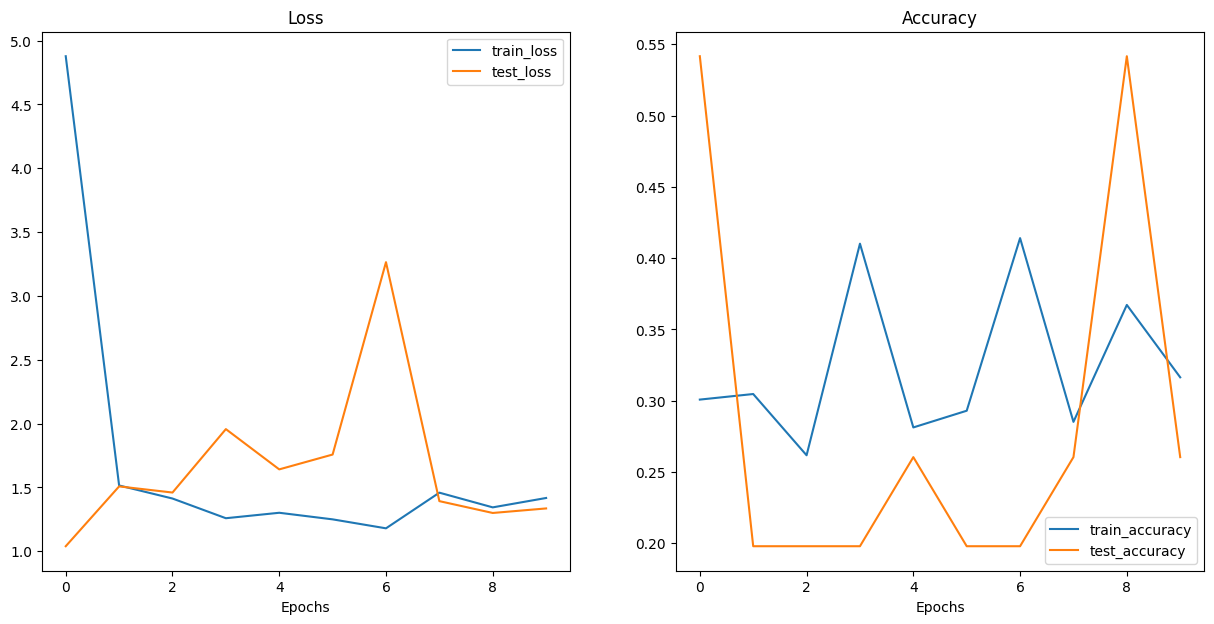

In [ ]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

## 10. Using a pretrained ViT model from `torchvision.models` on the same dataset

Generally, in deep learning if you can use a pretrained model from a large datast on your own problems, it's often good.

If you can find a pretrained model and use transfer learning, give it a go, it often achieves great resuilts with little data.





### 10.1 **Why we use pretrained data?**

* Sometimes data is limited
* Limited training resources
* Get better results faster (sometimes)


In [ ]:
#Cost of TPUv3 for 30 days
cost=30*24*8
print(f"Cost of renting a TPUv3 for 30 straight days: ${cost}USD")

Cost of renting a TPUv3 for 30 straight days: $5760USD


In [ ]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.3.0+cu121
0.18.0+cu121


'cuda'

### 10.2 Prepare a pretrained ViT for use for FoodVisionMini (turn it into a feature extractor)

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:07<00:00, 48.9MB/s]


In [ ]:
# # Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 10.3 Preparing data for our pretrained model

When using a pretrained model, you want to make sure the data is formatted in the same way the model was trained on

In [ ]:
from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


### 10.4 Train feature extractor ViT model

In [ ]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


### 10.5 Plot feature extractor ViT model loss curves

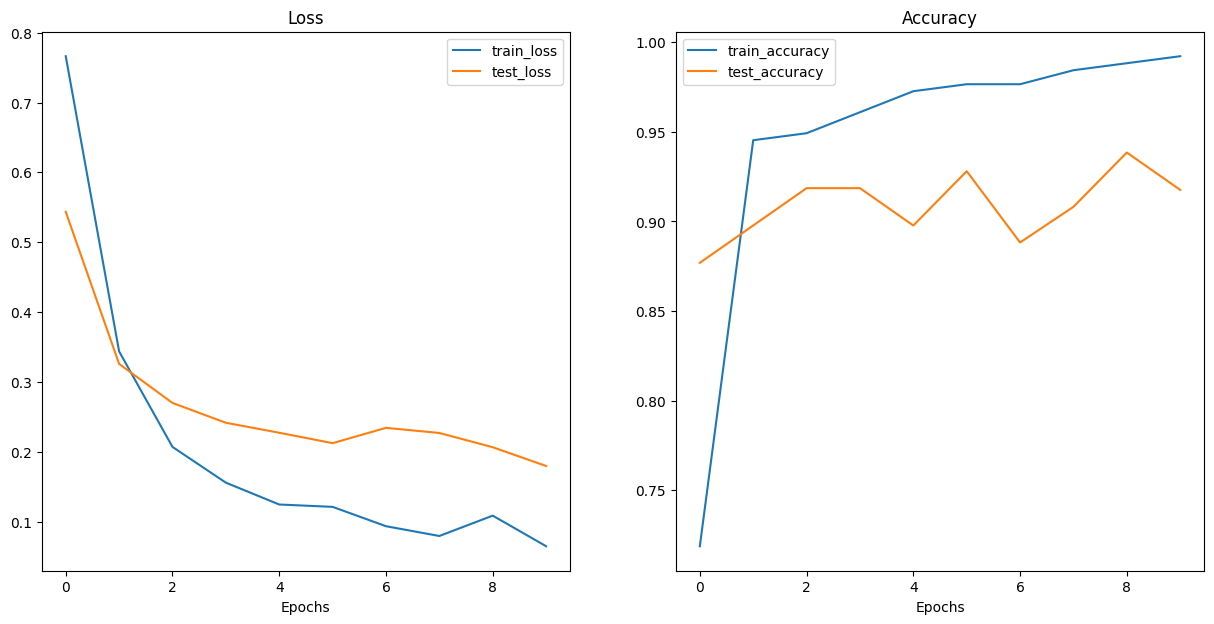

In [ ]:
from helper_functions import plot_loss_curves

# Plot our pretrained ViT model's loss curves
plot_loss_curves(pretrained_vit_results)

### 10.6 Save feature extractor ViT model and check file size

Now we've got a semi decent model, save it to file and check the file size.

We want to check the file size as if we wanted to deploy the model we'll have limitations on the size of model we can deploy.

E.g a smaller model may be required due to compute restrictions.

In [ ]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


Our pretrained ViT gets some of our best results we've seen so far for our own FoodVision Mini problem, however, the model size is ~11x larger than our next best performing model.

Perhaps the larger model size might cause issues when we go to deploy it (e.g hard to deploy such a large file/might not make predictions as fast as a smaller model).

## 11. Make predictions on a custom image

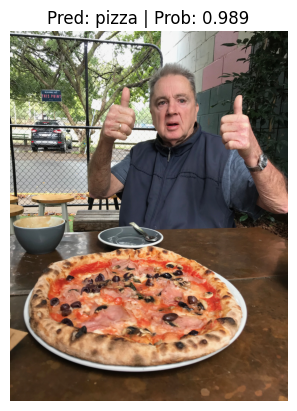

In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

## Main takeaways

Main takeaways
* With the explosion of machine learning, new research papers detailing advancements come out every day. And it's impossible to keep up with it all but you can narrow things down to your own use case, such as what we did here, replicating a computer vision paper for FoodVision Mini.
* Machine learning research papers often contain months of research by teams of smart people compressed into a few pages (so teasing out all the details and replicating the paper in full can be a bit of challenge).
* The goal of paper replicating is to turn machine learning research papers (text and math) into usable code.
  * With this being said, many machine learning research teams are starting to publish code with their papers and one of the best places to see this is at Paperswithcode.com
* Breaking a machine learning research paper into inputs and outputs (what goes in and out of each layer/block/model?) and layers (how does each layer manipulate the input?) and blocks (a collection of layers) and replicating each part step by step (like we've done in this notebook) can be very helpful for understanding.
* Pretrained models are available for many state of the art model architectures and with the power of transfer learning, these often perform very well with little data.
* Larger models generally perform better but have a larger footprint too (they take up more storage space and can take longer to perform inference).
  * A big question is: deployment wise, is the extra performance of a larger model worth it/aligned with the use case?

## Exercises